In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from joblib import dump, load
from analysis.offsets import offsets
from scipy.stats import multivariate_normal

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/manifold/")

%matplotlib inline

### multiIndexing

In [2]:
# https://stackoverflow.com/questions/36760414/how-to-create-pandas-dataframes-with-more-than-2-dimensions
# https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#advanced-xs
channels = np.arange(64)
n_timepoints = 2000
n_targets = 12
n_blocks = 45
# n_subjects = 46
subject_block_target_time_channel = np.tile(channels, (n_blocks,n_targets,n_timepoints,1))
print(subject_block_target_time_channel.shape,np.product(subject_block_target_time_channel.shape[:-1]))

timepoints = np.arange(n_timepoints)
targets = range(n_targets)
blocks = range(n_blocks)
# subjects = range(n_subjects)

(45, 12, 2000, 64) 1080000


In [3]:
multi_index = pd.MultiIndex.from_product([timepoints,targets,blocks][::-1],names=["time", "target", "block"][::-1])
multi_index.shape

(1080000,)

In [4]:
test_df = pd.DataFrame(subject_block_target_time_channel.reshape(-1,64),index=multi_index,columns=channels)

In [5]:
subject_idx = 22
subject_emg_stacks = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")

In [6]:
subject_emg_stacks.shape

(45, 12, 64, 2000)

In [7]:
df = np.log(pd.DataFrame(subject_emg_stacks.transpose(0,1,3,2).reshape(-1,64),index=multi_index,columns=channels).drop(labels=56,axis=1).dropna())

In [8]:
df.shape

(153647, 63)

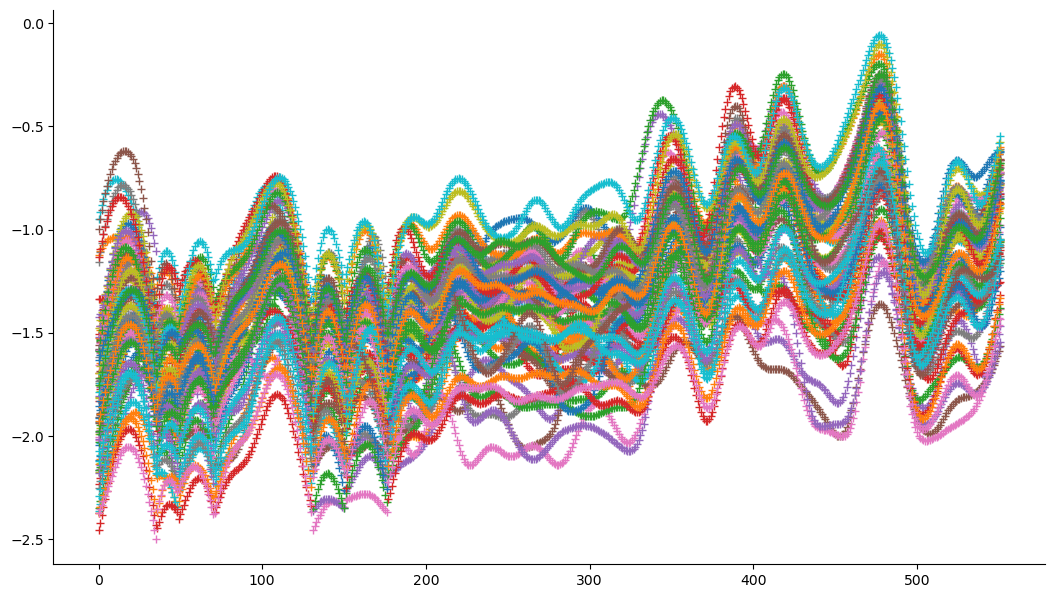

In [9]:
for ch in channels:
    if ch != 56:
        plt.plot(df.xs(0,level="block").xs(1,level="target")[ch])

In [10]:
def name_to_color(index_list):
    numbers = np.array([int(el.split(" ")[-1]) for el in index_list])
    return numbers / numbers.max()

def index_to_color(numbers):
    return np.array(numbers) / np.max(numbers)

def map_to_range(output_range, array):
    min = array.min()
    max = array.max()
    return output_range[0] + ((array - min)*(output_range[1]-output_range[0])) / (max - min)

In [11]:
# https://pair-code.github.io/understanding-umap/
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap
reducer = umap.UMAP(n_components=2,n_neighbors=500,min_dist=0.3)
embedding = reducer.fit_transform(df)
embedding_df = pd.DataFrame(embedding)
del embedding

/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


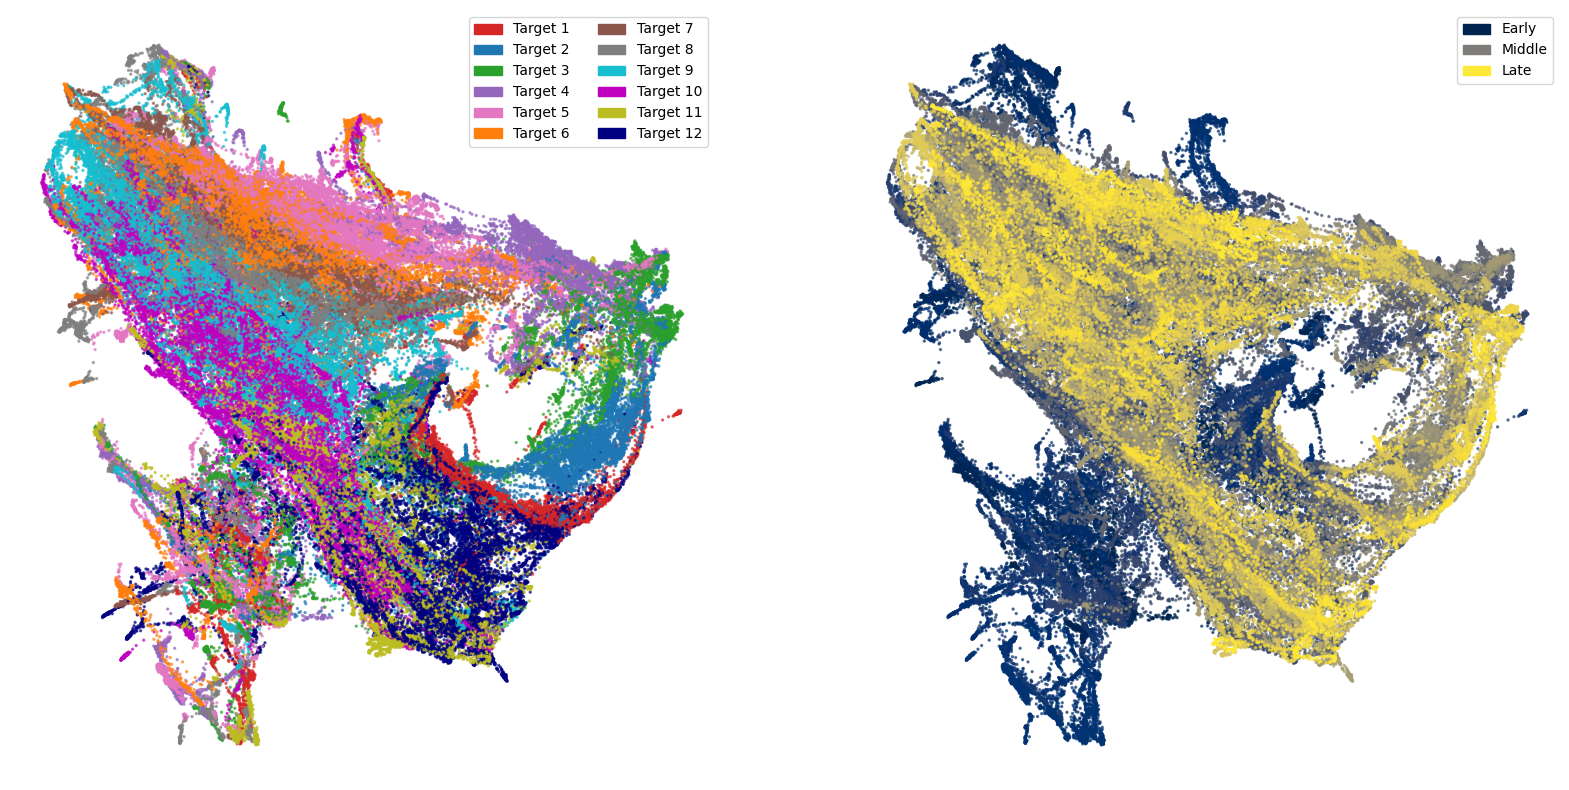

In [19]:
umap_fig, axes = plt.subplots(1,2,figsize=(20,10))
colors = ["tab:red","tab:blue","tab:green","tab:purple","tab:pink","tab:orange","tab:brown","tab:grey","tab:cyan","m","tab:olive","navy"]
block_names = df.index.get_level_values("block").tolist()
target_names = df.index.get_level_values("target").tolist()
time_indices = np.array(df.index.get_level_values("time").tolist())
embedding_df.plot(kind="scatter",colorbar=False,x=0,y=1,s=2*np.ones(shape=(embedding_df.shape[0])),c=[colors[i] for i in target_names],colormap="Set3",alpha=0.6,ax=axes[0])
embedding_df.plot(kind="scatter",colorbar=False,x=0,y=1,s=2*np.ones(shape=(embedding_df.shape[0])),c=index_to_color(block_names),colormap="cividis",alpha=0.6,ax=axes[1])
for ax in axes:
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

handles = [patches.Patch(color=c) for c in colors]
axes[0].legend(handles=handles, labels=[f"Target {i+1}" for i in range(12)],loc=1,ncols=2)

handles = [patches.Patch(color=mpl.colormaps["cividis"](i)) for i in [0.0,0.5,1.0]]
axes[1].legend(handles=handles, labels=["Early", "Middle", "Late"],loc=1)

In [20]:
plot.save_figure(umap_fig, "example_umap_22",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/manifold/example_umap_22.pdf


In [14]:
df.index.names

FrozenList(['block', 'target', 'time'])

In [15]:
chunk_indices = analysis.make_chunk_indices()
colors = ["tab:red","tab:blue","tab:green","tab:purple","tab:pink","tab:orange","tab:brown","tab:grey","tab:cyan","m","tab:olive","navy"]
embeddings = []
df_chunks = []
for idx in chunk_indices:
    r = list(range(idx[0],idx[1]))
    df_chunk = df.iloc[df.index.get_level_values("block").isin(r)]
    df_chunks.append(df_chunk)
    reducer = umap.UMAP(n_components=2,n_neighbors=500,min_dist=0.5)
    embedding_chunk = reducer.fit_transform(df_chunk)
    embedding_chunk_df = pd.DataFrame(embedding_chunk)
    embeddings.append(embedding_chunk_df)

RangeIndex(start=0, stop=22519, step=1)


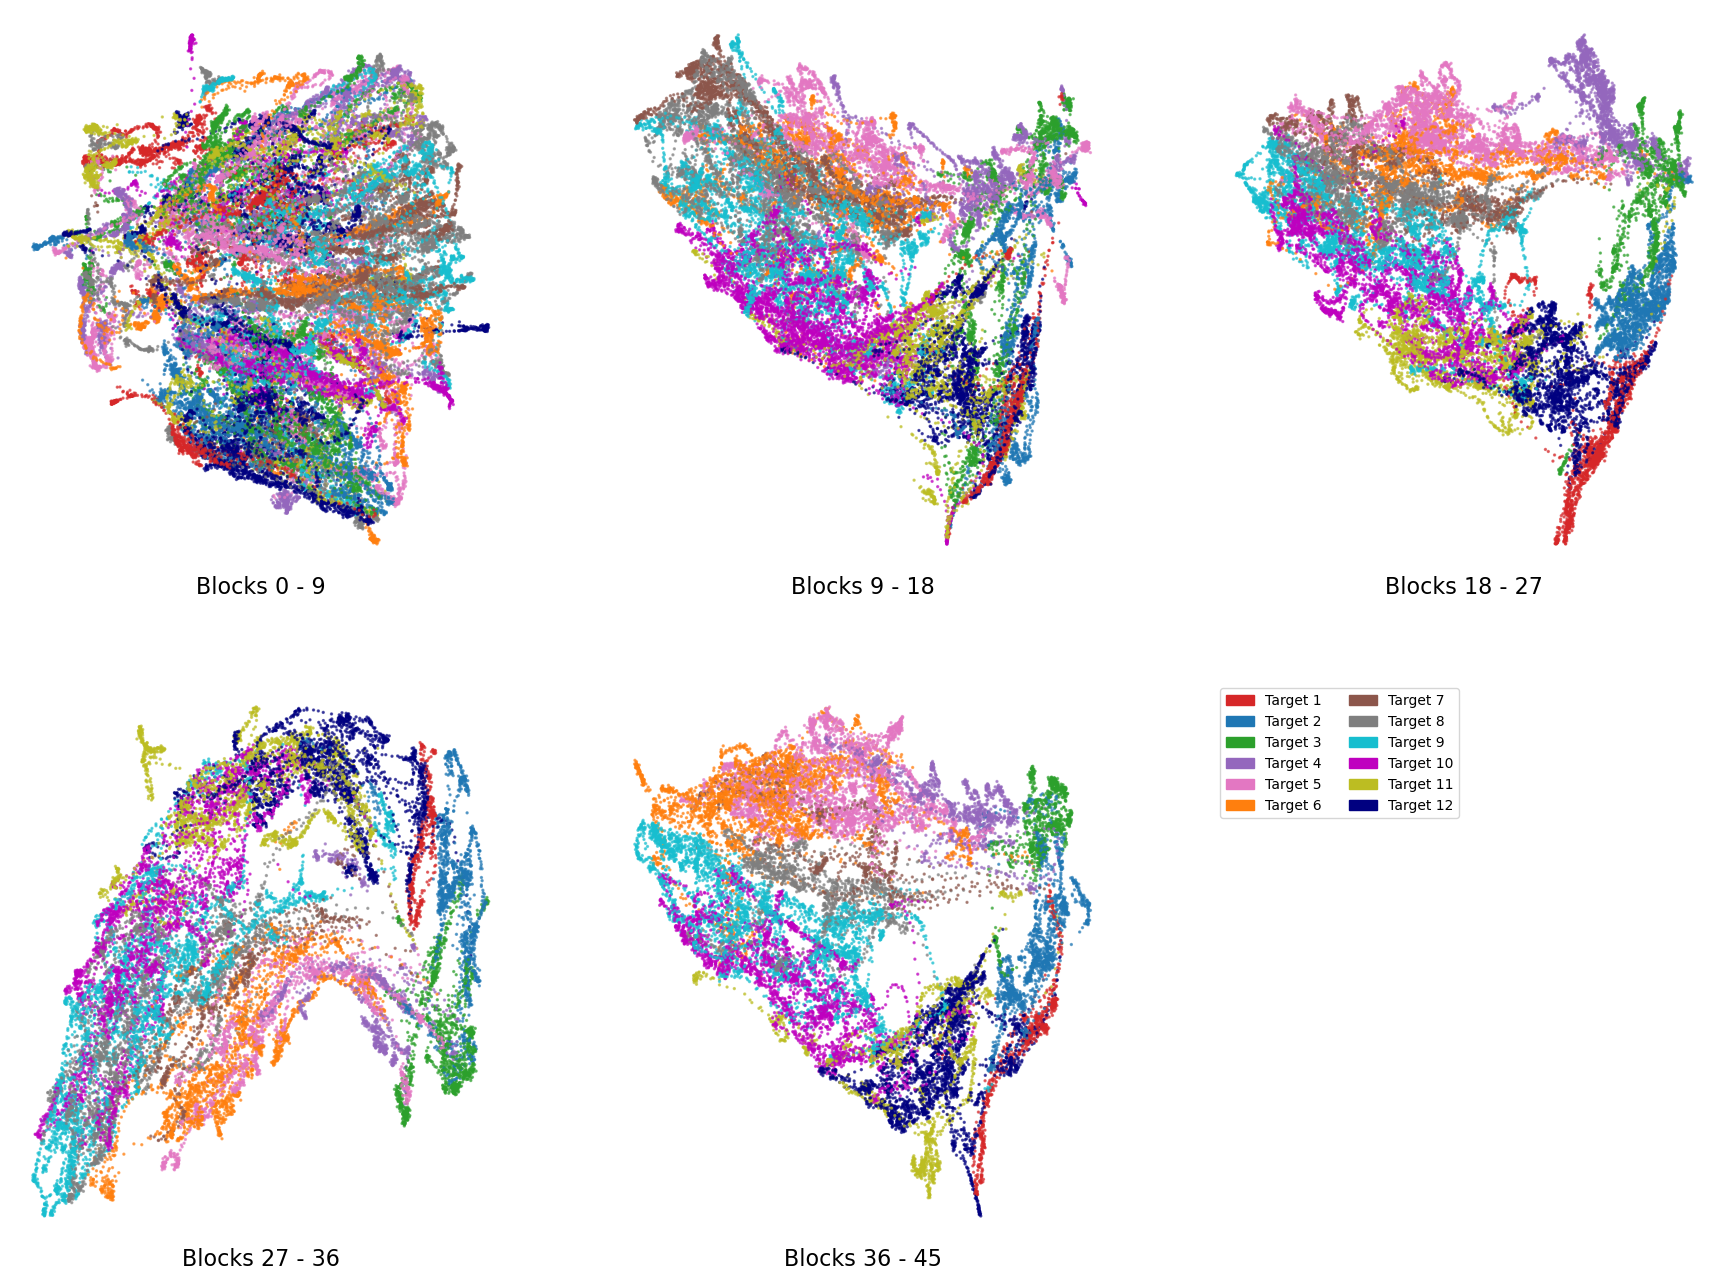

In [16]:
fig, axes = plt.subplots(2,3,figsize=(22,16))
axes = axes.ravel()
print(embedding_chunk_df.index)
for i, (embedding_chunk_df, df_chunk) in enumerate(zip(embeddings,df_chunks)):
    ax = axes[i]
    target_names = df_chunk.index.get_level_values("target").tolist()
    embedding_chunk_df.plot(kind="scatter",colorbar=False,x=0,y=1,s=2*np.ones(shape=(df_chunk.shape[0])),c=[colors[i] for i in target_names],alpha=0.6,ax=ax)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"Blocks {chunk_indices[i][0]} - {chunk_indices[i][1]}")
    ax.set_ylabel("")


axes[-1].set_frame_on(False)
axes[-1].set_xticks([])
axes[-1].set_yticks([])
axes[-1].set_xlabel("")
axes[-1].set_ylabel("")
handles = [patches.Patch(color=c) for c in colors]
axes[-1].legend(handles=handles, labels=[f"Target {i+1}" for i in range(12)],ncols=2,loc=2)

In [17]:
plot.save_figure(fig, "umap_over_blocks_22", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/manifold/umap_over_blocks_22.pdf


## Notes 

- Time seems to "compress" the data, becoming more similar (closer on the manifold) over time?
- Time encompasses more clusters, so more information than just time
- Targets aren't well separated into clusters, so what are the clusters?
- What correlates with cluster labels?
    - Signal mean, covariance
    - Reward 